In [1]:
import xml.etree.ElementTree as ET
from collections import defaultdict
import pandas as pd
import os
import re
from matplotlib_venn import venn2
import matplotlib.pyplot as plt
import networkx as nx
import traceback

class ZoteroIntegrator:
    def __init__(self):
        self.namespaces = {
            'rdf': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#',
            'z': 'http://www.zotero.org/namespaces/export#',
            'dc': 'http://purl.org/dc/elements/1.1/',
            'bib': 'http://purl.org/net/biblio#',
            'dcterms': 'http://purl.org/dc/terms/',
            'foaf': 'http://xmlns.com/foaf/0.1/'
        }
        # Store DataFrames as class attributes
        self.collections_df = None
        self.items_df = None
        self.collection_items_df = None
        self.records_df = None
        self.analysis_dfs = {}

    def normalize_title(self, title):
        """Normalize title for comparison."""
        if not title:
            return ""
        title = re.sub(r'[^\w\s]', '', title.lower())
        return ' '.join(title.split())

    def extract_from_rdf(self, rdf_path):
        """Extract collection structure and items from RDF and convert to DataFrames."""
        try:
            print(f"\nProcessing RDF: {rdf_path}")
            tree = ET.parse(rdf_path)
            root = tree.getroot()
            
            # Collections
            collections_data = []
            collection_items_data = []
            
            for collection in root.findall(f".//{{{self.namespaces['z']}}}Collection"):
                coll_id = collection.get(f"{{{self.namespaces['rdf']}}}about")
                if coll_id:
                    title = collection.find(f".//{{{self.namespaces['dc']}}}title")
                    if title is not None and title.text:
                        collections_data.append({
                            'collection_id': coll_id,
                            'title': title.text,
                            'parent': None
                        })
                        
                        # Collection items
                        for item_ref in collection.findall(f".//{{{self.namespaces['dcterms']}}}hasPart"):
                            item_id = item_ref.get(f"{{{self.namespaces['rdf']}}}resource")
                            if item_id:
                                collection_items_data.append({
                                    'collection_title': title.text,
                                    'item_id': item_id
                                })
            
            # Items
            items_data = []
            for item in root.findall(".//*[@rdf:about]", self.namespaces):
                item_id = item.get(f"{{{self.namespaces['rdf']}}}about")
                if item_id:
                    title = item.find(f".//{{{self.namespaces['dc']}}}title")
                    if title is not None and title.text:
                        items_data.append({
                            'item_id': item_id,
                            'title': title.text,
                            'normalized_title': self.normalize_title(title.text)
                        })
            
            # Convert to DataFrames
            collections_df = pd.DataFrame(collections_data)
            items_df = pd.DataFrame(items_data)
            collection_items_df = pd.DataFrame(collection_items_data)
            
            print(f"Found {len(collections_df)} collections and {len(items_df)} items")
            return collections_df, items_df, collection_items_df
            
        except Exception as e:
            print(f"Error in extract_from_rdf: {str(e)}")
            traceback.print_exc()
            return pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

    def extract_from_dedup_xml(self, xml_path):
        """Extract records from XML and convert to DataFrame."""
        try:
            print(f"\nProcessing deduplicated XML: {xml_path}")
            tree = ET.parse(xml_path)
            root = tree.getroot()
            
            records_data = []
            for record in root.findall('.//record'):
                try:
                    rec_data = {}
                    
                    # Extract fields
                    titles = record.find('.//titles')
                    if titles is not None:
                        title = titles.find('title')
                        if title is not None:
                            style = title.find('.//style')
                            if style is not None and style.text:
                                rec_data['title'] = style.text.strip()
                                rec_data['normalized_title'] = self.normalize_title(style.text)
                        
                        secondary = titles.find('secondary-title')
                        if secondary is not None:
                            style = secondary.find('.//style')
                            if style is not None and style.text:
                                rec_data['journal'] = style.text.strip()
                    
                    # Authors
                    authors = []
                    contributors = record.find('.//contributors')
                    if contributors is not None:
                        for author in contributors.findall('.//author'):
                            style = author.find('.//style')
                            if style is not None and style.text:
                                authors.append(style.text.strip())
                    rec_data['authors'] = '; '.join(authors)
                    
                    # Other fields
                    abstract = record.find('.//abstract')
                    if abstract is not None:
                        style = abstract.find('.//style')
                        if style is not None and style.text:
                            rec_data['abstract'] = style.text.strip()
                    
                    electronic_num = record.find('.//electronic-resource-num')
                    if electronic_num is not None:
                        style = electronic_num.find('.//style')
                        if style is not None and style.text:
                            rec_data['doi'] = style.text.strip()
                    
                    ref_type = record.find('.//ref-type')
                    if ref_type is not None:
                        rec_data['type'] = ref_type.get('name')
                    
                    if 'title' in rec_data:
                        records_data.append(rec_data)
                        
                except Exception as e:
                    print(f"Error processing record: {str(e)}")
                    continue
            
            records_df = pd.DataFrame(records_data)
            print(f"Extracted {len(records_df)} records from XML")
            return records_df
            
        except Exception as e:
            print(f"Error in extract_from_dedup_xml: {str(e)}")
            traceback.print_exc()
            return pd.DataFrame()

    def process_libraries(self, portal_rdf, portal_xml, search_rdf, search_xml):
        """Process both libraries and store results in class attributes."""
        # Process Portal library
        print("\nProcessing Portal library...")
        portal_collections, portal_items, portal_coll_items = self.extract_from_rdf(portal_rdf)
        portal_records = self.extract_from_dedup_xml(portal_xml)
        portal_collections['library'] = 'Portal'
        portal_items['library'] = 'Portal'
        portal_coll_items['library'] = 'Portal'
        portal_records['library'] = 'Portal'
        
        # Process Search library
        print("\nProcessing Search library...")
        search_collections, search_items, search_coll_items = self.extract_from_rdf(search_rdf)
        search_records = self.extract_from_dedup_xml(search_xml)
        search_collections['library'] = 'Search'
        search_items['library'] = 'Search'
        search_coll_items['library'] = 'Search'
        search_records['library'] = 'Search'
        
        # Combine DataFrames
        self.collections_df = pd.concat([portal_collections, search_collections], ignore_index=True)
        self.items_df = pd.concat([portal_items, search_items], ignore_index=True)
        self.collection_items_df = pd.concat([portal_coll_items, search_coll_items], ignore_index=True)
        self.records_df = pd.concat([portal_records, search_records], ignore_index=True)
        
        # Create analysis DataFrames
        self.create_analysis_dfs()
        
        return {
            'collections': self.collections_df,
            'items': self.items_df,
            'collection_items': self.collection_items_df,
            'records': self.records_df,
            'analysis': self.analysis_dfs
        }

    def create_analysis_dfs(self):
        """Create analysis DataFrames."""
        # Collection statistics
        coll_stats = self.collection_items_df.groupby(['library', 'collection_title']).agg({
            'item_id': 'count'
        }).reset_index()
        coll_stats.columns = ['Library', 'Collection', 'Total Items']
        
        # Duplicate analysis
        portal_items = self.records_df[self.records_df['library'] == 'Portal']['normalized_title'].unique()
        search_items = self.records_df[self.records_df['library'] == 'Search']['normalized_title'].unique()
        duplicates = set(portal_items).intersection(set(search_items))
        
        dupes_df = self.records_df[self.records_df['normalized_title'].isin(duplicates)].copy()
        
        # Summary metrics
        summary = pd.DataFrame([
            {'Metric': 'Total Portal Items', 'Value': len(portal_items)},
            {'Metric': 'Total Search Items', 'Value': len(search_items)},
            {'Metric': 'Duplicate Items', 'Value': len(duplicates)}
        ])
        
        self.analysis_dfs = {
            'collection_stats': coll_stats,
            'duplicates': dupes_df,
            'summary': summary
        }

def process_zotero_libraries(base_dir):
    """Process Zotero libraries and return DataFrames."""
    files = {
        'portal': {
            'rdf': os.path.join(base_dir, 'Nechako Portal/Nechako Portal.rdf'),
            'xml': os.path.join(base_dir, 'Nechako Portal/Deduplicator/Untitled_deduplicated 2024-12-02_Time0909.xml')
        },
        'search': {
            'rdf': os.path.join(base_dir, 'Nechako Saturation Search/Nechako Saturation Search (2024-04).rdf'),
            'xml': os.path.join(base_dir, 'Nechako Saturation Search/Deduplicator/Untitled_deduplicated 2024-12-02_Time0911.xml')
        }
    }
    
    integrator = ZoteroIntegrator()
    return integrator.process_libraries(
        files['portal']['rdf'],
        files['portal']['xml'],
        files['search']['rdf'],
        files['search']['xml']
    )

In [2]:
# Set your base directory
base_dir = '/Users/ahmadjalil/Desktop/Zotero Project'

# Process the libraries and get all DataFrames
dfs = process_zotero_libraries(base_dir)

# Access individual DataFrames
collections_df = dfs['collections']
items_df = dfs['items']
collection_items_df = dfs['collection_items']
records_df = dfs['records']

# Access analysis DataFrames
collection_stats_df = dfs['analysis']['collection_stats']
duplicates_df = dfs['analysis']['duplicates']
summary_df = dfs['analysis']['summary']

# Now you can work with these DataFrames
# For example, to see duplicate items:
print(duplicates_df[['title', 'library', 'journal']].head())

# Or to see collection statistics:
print(collection_stats_df.sort_values('Total Items', ascending=False).head())


Processing Portal library...

Processing RDF: /Users/ahmadjalil/Desktop/Zotero Project/Nechako Portal/Nechako Portal.rdf
Found 31 collections and 4361 items

Processing deduplicated XML: /Users/ahmadjalil/Desktop/Zotero Project/Nechako Portal/Deduplicator/Untitled_deduplicated 2024-12-02_Time0909.xml
Extracted 1696 records from XML

Processing Search library...

Processing RDF: /Users/ahmadjalil/Desktop/Zotero Project/Nechako Saturation Search/Nechako Saturation Search (2024-04).rdf
Found 4 collections and 1192 items

Processing deduplicated XML: /Users/ahmadjalil/Desktop/Zotero Project/Nechako Saturation Search/Deduplicator/Untitled_deduplicated 2024-12-02_Time0911.xml
Extracted 765 records from XML
                                               title library  \
1   Myths of the Carrier Indians of British Columbia  Portal   
2  The Physical Basis of Agriculture in British C...  Portal   
3  Claiming Memory in British Columbia: Aborigina...  Portal   
4  As if Indigenous Knowledge and

Library Structure Analysis

1. Library Size Overview:
Portal Library: 1696 entries
Search Library: 765 entries

2. Collection Structure Analysis:
Portal Library Collections: 31
Search Library Collections: 4


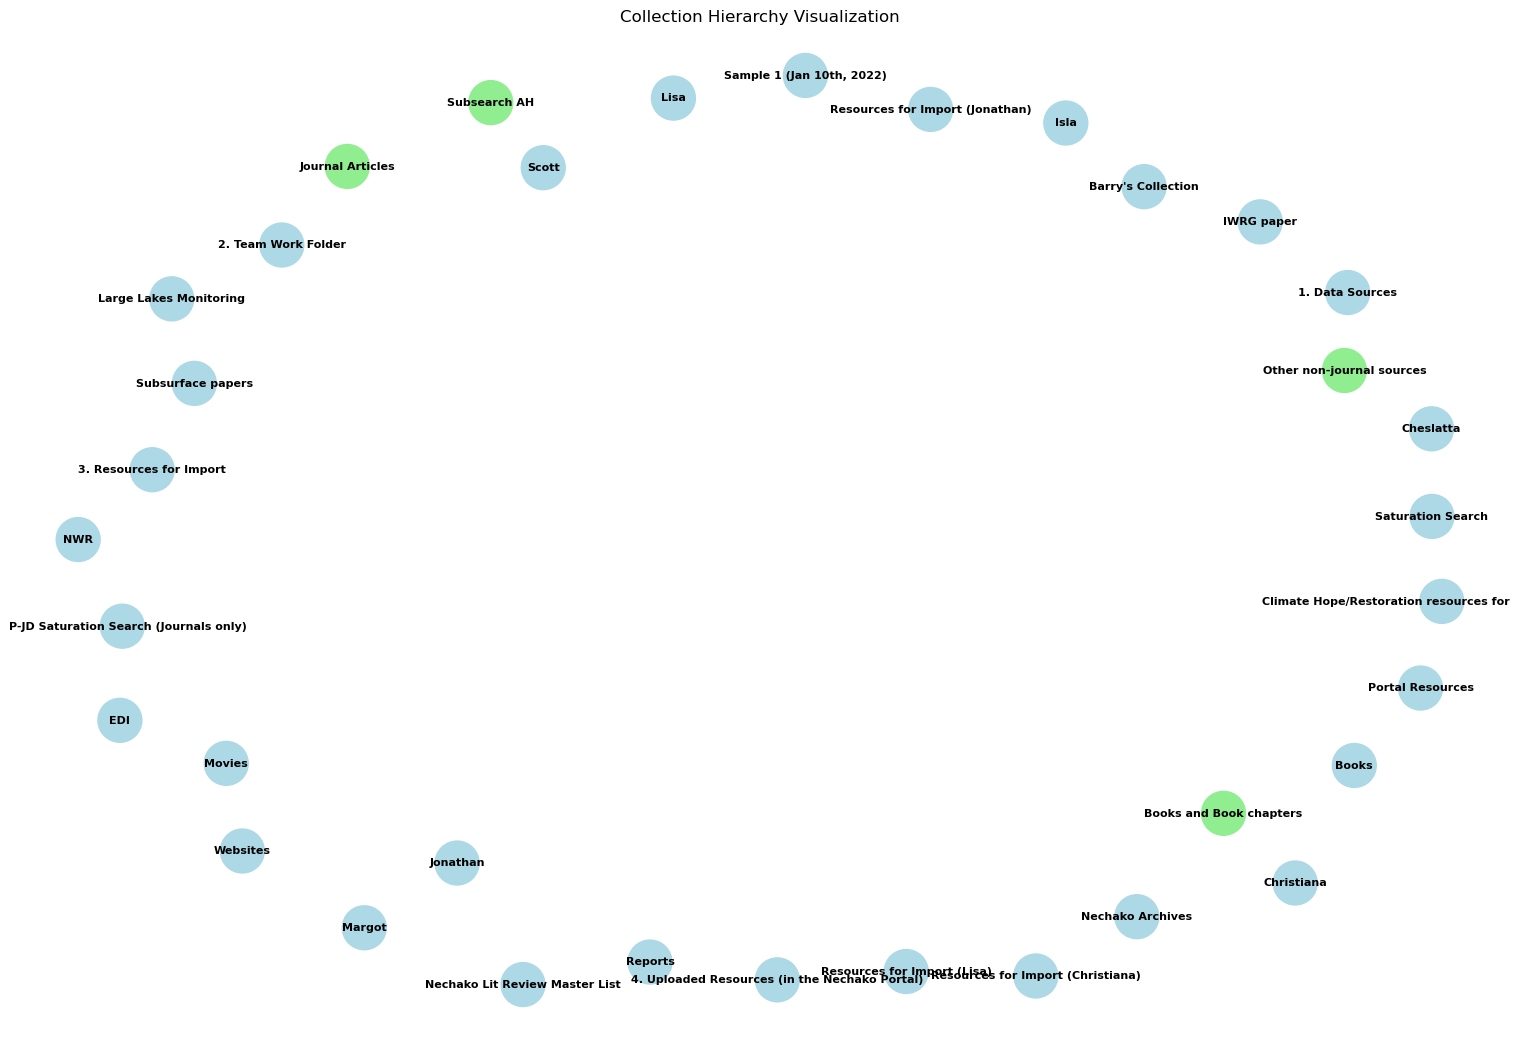


3. Document Type Distribution:
type     Artwork  Audiovisual Material  Blog  Book  Book Section  Case  \
library                                                                  
Portal         1                    22     4    92            18    16   
Search         0                     0     0     0             1     0   

type     Conference Proceedings  Film or Broadcast  Generic  Journal Article  \
library                                                                        
Portal                       28                  1       44              974   
Search                       20                  1       26              695   

type     Magazine Article  Map  Newspaper Article  Report  Thesis  Web Page  
library                                                                      
Portal                  7    1                 96     130      92       170  
Search                 14    0                  0       0       8         0  



4. Duplicate Analysis:
Total duplicates found: 702

Duplicate distribution across document types:
library                 Portal  Search
type                                  
Blog                         1       0
Book                         1       0
Book Section                 0       1
Conference Proceedings      15      17
Film or Broadcast            0       1
Generic                      0      25
Journal Article            675     629
Magazine Article             0      10
Report                       1       0
Thesis                       9       6
Web Page                    14       0

5. Content Matching Analysis:
Entries with DOIs (for matching): 1294 (52.6%)



6. Summary Statistics:
Total Entries: 2461
Unique Documents: 1753
Total Collections: 35
Duplicate Sets: 702
Entries with DOIs: 1294
Document Types: 16

Detailed Collection Statistics:
   Library                                         Collection  Total Items
13  Portal                                   Nechako Archives          779
25  Search                                   Journal Articles          696
10  Portal            MP-JD Saturation Search (Journals only)          499
14  Portal                     Nechako Lit Review Master List          469
3   Portal      4. Uploaded Resources (in the Nechako Portal)          460
9   Portal                             Large Lakes Monitoring          152
20  Portal                          Sample 1 (Jan 10th, 2022)           79
4   Portal                                              Books           78
17  Portal                  Resources for Import (Christiana)           78
18  Portal                    Resources for Import (Jonathan)    

In [4]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict

def analyze_library_structure(dfs):
    """
    Analyze and visualize the structure and content distribution of Zotero libraries.
    """
    records_df = dfs['records']
    collections_df = dfs['collections']
    collection_stats_df = dfs['analysis']['collection_stats']
    
    print("Library Structure Analysis")
    print("=" * 50)
    
    # 1. Library Size Overview
    print("\n1. Library Size Overview:")
    lib_sizes = records_df.groupby('library').size()
    for lib, size in lib_sizes.items():
        print(f"{lib} Library: {size} entries")
    
    # 2. Collection Structure Analysis
    print("\n2. Collection Structure Analysis:")
    collection_counts = collections_df.groupby('library')['collection_id'].count()
    for lib, count in collection_counts.items():
        print(f"{lib} Library Collections: {count}")
    
    # Create collection hierarchy visualization
    plt.figure(figsize=(15, 10))
    G = nx.Graph()
    
    # Add nodes for collections
    for _, row in collections_df.iterrows():
        G.add_node(row['title'], library=row['library'])
        if pd.notna(row['parent']):
            G.add_edge(row['title'], 
                      collections_df[collections_df['collection_id'] == row['parent']]['title'].iloc[0])
    
    # Draw the graph
    pos = nx.spring_layout(G)
    colors = ['lightblue' if d['library'] == 'Portal' else 'lightgreen' 
              for _, d in G.nodes(data=True)]
    
    nx.draw(G, pos, 
           node_color=colors,
           node_size=1000,
           font_size=8,
           font_weight='bold',
           with_labels=True)
    
    plt.title("Collection Hierarchy Visualization")
    plt.show()
    
    # 3. Document Type Distribution
    print("\n3. Document Type Distribution:")
    doc_type_dist = pd.crosstab(records_df['library'], records_df['type'])
    print(doc_type_dist)
    
    # Visualize document type distribution
    fig = px.bar(records_df.groupby(['library', 'type']).size().reset_index(name='count'),
                 x='type',
                 y='count',
                 color='library',
                 title='Document Types Across Libraries',
                 barmode='group')
    fig.show()
    
    # 4. Duplicate Analysis
    duplicates = records_df[records_df.duplicated(subset='normalized_title', keep=False)]
    print("\n4. Duplicate Analysis:")
    print(f"Total duplicates found: {len(duplicates) // 2}")
    
    # Analyze duplicate distribution across document types
    dup_type_dist = duplicates.groupby(['type', 'library']).size().unstack(fill_value=0)
    print("\nDuplicate distribution across document types:")
    print(dup_type_dist)
    
    # 5. Content Matching Analysis
    print("\n5. Content Matching Analysis:")
    matched_entries = len(records_df[records_df['doi'].notna()])
    print(f"Entries with DOIs (for matching): {matched_entries} ({matched_entries/len(records_df)*100:.1f}%)")
    
    # Create content distribution heatmap
    if 'journal' in records_df.columns:
        top_journals = records_df.groupby('journal').size().sort_values(ascending=False).head(15)
        journal_lib_dist = pd.crosstab(records_df['journal'], records_df['library'])
        journal_lib_dist = journal_lib_dist.loc[top_journals.index]
        
        fig = go.Figure(data=go.Heatmap(
            z=journal_lib_dist.values,
            x=journal_lib_dist.columns,
            y=journal_lib_dist.index,
            colorscale='Viridis'))
        
        fig.update_layout(
            title='Content Distribution Across Libraries (Top 15 Journals)',
            xaxis_title='Library',
            yaxis_title='Journal',
            height=600)
        fig.show()
    
    # 6. Summary Statistics
    summary_stats = {
        'Total Entries': len(records_df),
        'Unique Documents': len(records_df['normalized_title'].unique()),
        'Total Collections': len(collections_df),
        'Duplicate Sets': len(duplicates) // 2,
        'Entries with DOIs': matched_entries,
        'Document Types': len(records_df['type'].unique())
    }
    
    print("\n6. Summary Statistics:")
    for stat, value in summary_stats.items():
        print(f"{stat}: {value}")
    
    return {
        'summary_stats': summary_stats,
        'collection_hierarchy': G,
        'duplicate_analysis': dup_type_dist,
        'document_distribution': doc_type_dist
    }

# Run the analysis
structure_analysis = analyze_library_structure(dfs)

# Print detailed collection statistics
print("\nDetailed Collection Statistics:")
print("=" * 50)
unique_titles_per_collection = dfs['analysis']['collection_stats'].sort_values('Total Items', ascending=False)
print(unique_titles_per_collection)


Summary Statistics:
--------------------------------------------------

Overall Library Statistics:

Portal Library:
Total Items: 1696
Unique Document Types: 16
Unique Journals: 652

Search Library:
Total Items: 765
Unique Document Types: 7
Unique Journals: 432

Duplicate Analysis:
Total Duplicates Found: 702

Duplicate Document Types:
Journal Article: 1304
Conference Proceedings: 32
Generic: 25
Thesis: 15
Web Page: 14
Magazine Article: 10
Blog: 1
Book: 1
Book Section: 1
Film or Broadcast: 1
Report: 1


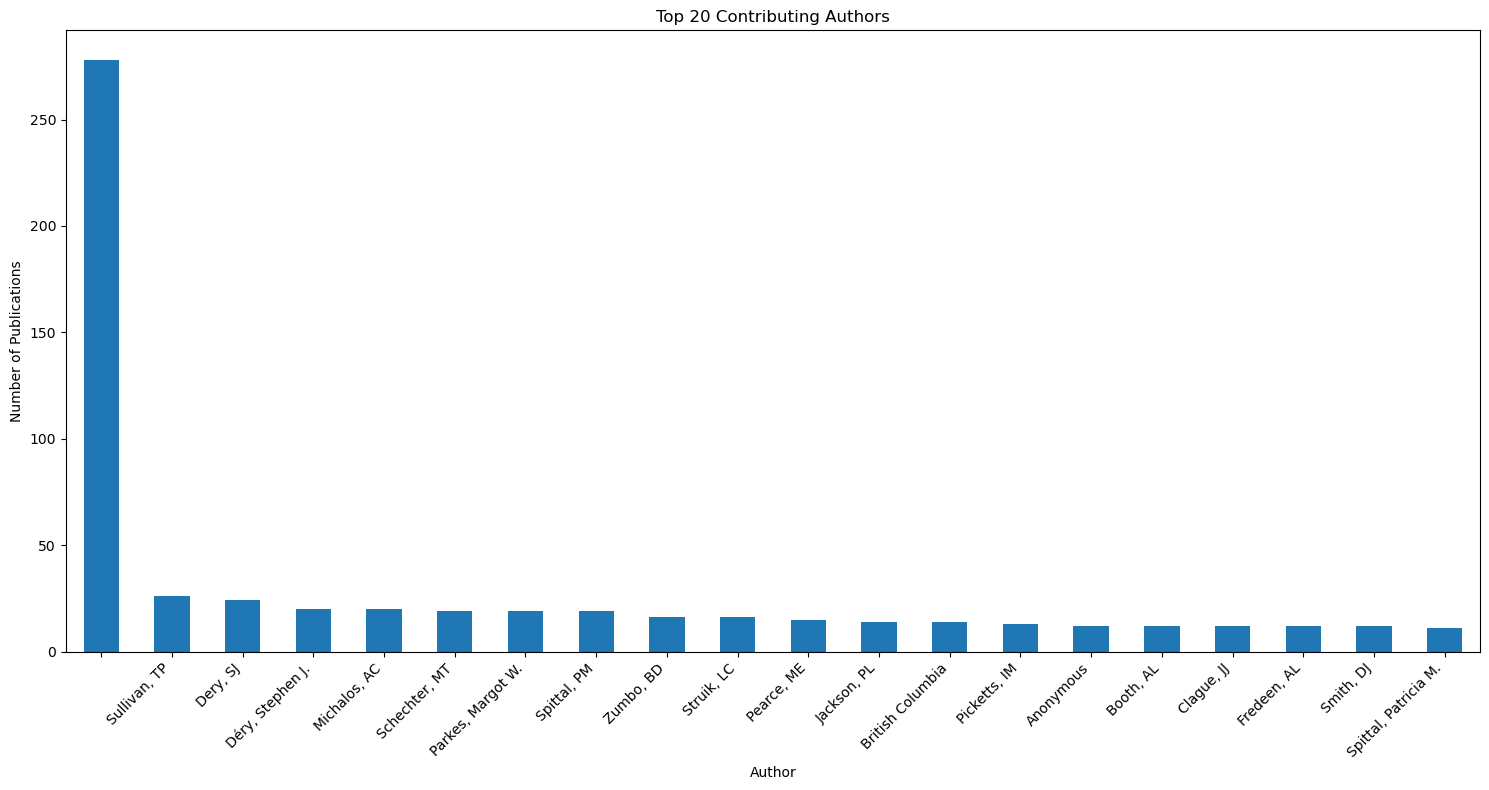


Top 10 most frequent document types:
   library                    type  count
9   Portal         Journal Article    974
20  Search         Journal Article    695
15  Portal                Web Page    170
13  Portal                  Report    130
12  Portal       Newspaper Article     96
3   Portal                    Book     92
14  Portal                  Thesis     92
8   Portal                 Generic     44
6   Portal  Conference Proceedings     28
19  Search                 Generic     26

Top 10 journals with most publications:
                                                journal library  count
153                  CANADIAN JOURNAL OF EARTH SCIENCES  Search     42
152                  CANADIAN JOURNAL OF EARTH SCIENCES  Portal     36
1026                                  The Vancouver Sun  Portal     26
251   Canadian Journal of Fisheries and Aquatic Scie...  Portal     25
248                  Canadian Journal of Earth Sciences  Portal     19
937                          SOCI

In [5]:
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

def create_library_analysis(dfs):
    """
    Create comprehensive analysis and visualizations of the Zotero libraries
    using the DataFrames created earlier.
    """
    records_df = dfs['records']
    collections_df = dfs['collections']
    collection_stats_df = dfs['analysis']['collection_stats']
    
    # 1. Collection Size Distribution
    fig = px.bar(collection_stats_df,
                 x='Collection',
                 y='Total Items',
                 color='Library',
                 title='Collection Sizes Across Libraries',
                 labels={'Total Items': 'Number of Items'},
                 height=500)
    fig.update_xaxes(tickangle=45)
    fig.show()
    
    # 2. Document Types Distribution
    doc_types = records_df.groupby(['library', 'type']).size().reset_index(name='count')
    fig = px.bar(doc_types,
                 x='type',
                 y='count',
                 color='library',
                 title='Document Types Distribution by Library',
                 barmode='group',
                 height=500)
    fig.update_xaxes(tickangle=45)
    fig.show()
    
    # 3. Journal Distribution
    journal_counts = records_df.groupby(['journal', 'library']).size().reset_index(name='count')
    top_journals = journal_counts.sort_values('count', ascending=False).head(20)
    
    fig = px.bar(top_journals,
                x='journal',
                y='count',
                color='library',
                title='Top 20 Journals Distribution',
                barmode='group',
                height=500)
    fig.update_xaxes(tickangle=45)
    fig.show()
    
    # 4. Summary Statistics
    print("\nSummary Statistics:")
    print("-" * 50)
    
    # Overall statistics
    print("\nOverall Library Statistics:")
    for lib in ['Portal', 'Search']:
        lib_stats = records_df[records_df['library'] == lib]
        print(f"\n{lib} Library:")
        print(f"Total Items: {len(lib_stats)}")
        print(f"Unique Document Types: {len(lib_stats['type'].unique())}")
        print(f"Unique Journals: {len(lib_stats['journal'].unique())}")
    
    # Duplicate statistics
    duplicate_titles = records_df[records_df.duplicated(subset='normalized_title', keep=False)]
    print("\nDuplicate Analysis:")
    duplicate_count = len(duplicate_titles) // 2
    print(f"Total Duplicates Found: {duplicate_count}")
    
    # Document type breakdown for duplicates
    print("\nDuplicate Document Types:")
    dup_types = duplicate_titles.groupby('type').size().sort_values(ascending=False)
    for doc_type, count in dup_types.items():
        print(f"{doc_type}: {count}")
    
    # 5. Author Analysis
    # Split authors string into list and get unique authors
    records_df['author_list'] = records_df['authors'].str.split('; ')
    all_authors = [author for authors in records_df['author_list'].dropna() for author in authors]
    top_authors = pd.Series(all_authors).value_counts().head(20)
    
    plt.figure(figsize=(15, 8))
    top_authors.plot(kind='bar')
    plt.title('Top 20 Contributing Authors')
    plt.xlabel('Author')
    plt.ylabel('Number of Publications')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    # 6. Publication Timeline (if we have dates)
    if 'date' in records_df.columns:
        timeline = records_df.groupby(['date', 'library']).size().reset_index(name='count')
        fig = px.line(timeline,
                     x='date',
                     y='count',
                     color='library',
                     title='Publication Timeline',
                     labels={'count': 'Number of Publications'})
        fig.show()
    
    return {
        'document_types': doc_types,
        'journal_distribution': journal_counts,
        'duplicate_analysis': duplicate_titles.groupby(['library', 'type']).size(),
        'top_authors': top_authors
    }

# Run the analysis
analysis_results = create_library_analysis(dfs)

# You can access specific results:
print("\nTop 10 most frequent document types:")
print(analysis_results['document_types'].sort_values('count', ascending=False).head(10))

print("\nTop 10 journals with most publications:")
print(analysis_results['journal_distribution'].sort_values('count', ascending=False).head(10))

In [6]:
def export_unique_entries(dfs, output_path='unique_entries_analysis.xlsx'):
    """
    Export entries that are unique to each library to an Excel file.
    """
    records_df = dfs['records']
    
    # Find unique entries for each library
    duplicate_titles = records_df[records_df.duplicated(subset='normalized_title', keep=False)]['normalized_title'].unique()
    
    # Get entries unique to Portal
    portal_unique = records_df[
        (records_df['library'] == 'Portal') & 
        (~records_df['normalized_title'].isin(duplicate_titles))
    ].copy()
    
    # Get entries unique to Search
    search_unique = records_df[
        (records_df['library'] == 'Search') & 
        (~records_df['normalized_title'].isin(duplicate_titles))
    ].copy()
    
    # Sort both dataframes by title
    portal_unique = portal_unique.sort_values('title')
    search_unique = search_unique.sort_values('title')
    
    # Create summary statistics
    summary_stats = pd.DataFrame({
        'Metric': [
            'Total Unique to Portal',
            'Total Unique to Search',
            'Portal Journal Articles',
            'Search Journal Articles',
            'Portal Items with DOI',
            'Search Items with DOI'
        ],
        'Count': [
            len(portal_unique),
            len(search_unique),
            len(portal_unique[portal_unique['type'] == 'Journal Article']),
            len(search_unique[search_unique['type'] == 'Journal Article']),
            len(portal_unique[portal_unique['doi'].notna()]),
            len(search_unique[search_unique['doi'].notna()])
        ]
    })
    
    # Select columns for export
    export_columns = ['title', 'authors', 'journal', 'type', 'doi']
    
    # Create Excel writer
    with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
        # Write summary statistics
        summary_stats.to_excel(writer, sheet_name='Summary', index=False)
        
        # Write unique Portal entries
        portal_unique[export_columns].to_excel(
            writer, 
            sheet_name='Portal Unique', 
            index=False
        )
        
        # Write unique Search entries
        search_unique[export_columns].to_excel(
            writer, 
            sheet_name='Search Unique', 
            index=False
        )
        
        # Write document type breakdown
        pd.DataFrame({
            'Portal Document Types': portal_unique['type'].value_counts(),
            'Search Document Types': search_unique['type'].value_counts()
        }).to_excel(writer, sheet_name='Document Types')
        
        # Write journal breakdown
        pd.DataFrame({
            'Portal Journals': portal_unique['journal'].value_counts().head(20),
            'Search Journals': search_unique['journal'].value_counts().head(20)
        }).to_excel(writer, sheet_name='Top Journals')
    
    print(f"\nExcel file created: {output_path}")
    print("\nSummary of unique entries:")
    print(f"Portal unique entries: {len(portal_unique)}")
    print(f"Search unique entries: {len(search_unique)}")
    
    return {
        'portal_unique': portal_unique,
        'search_unique': search_unique,
        'summary': summary_stats
    }

# Export the unique entries
unique_entries = export_unique_entries(dfs)

# Print additional statistics
print("\nDocument type breakdown for unique Portal entries:")
print(unique_entries['portal_unique']['type'].value_counts().head())
print("\nDocument type breakdown for unique Search entries:")
print(unique_entries['search_unique']['type'].value_counts().head())


Excel file created: unique_entries_analysis.xlsx

Summary of unique entries:
Portal unique entries: 980
Search unique entries: 76

Document type breakdown for unique Portal entries:
type
Journal Article      299
Web Page             156
Report               129
Newspaper Article     96
Book                  91
Name: count, dtype: int64

Document type breakdown for unique Search entries:
type
Journal Article           66
Magazine Article           4
Conference Proceedings     3
Thesis                     2
Generic                    1
Name: count, dtype: int64


In [7]:
def analyze_duplicates(records_df):
    """
    Analyze duplicates between libraries with improved accuracy.
    
    Args:
        records_df: DataFrame containing records from both libraries
    """
    # Separate records by library
    portal_records = records_df[records_df['library'] == 'Portal']
    search_records = records_df[records_df['library'] == 'Search']
    
    # Create sets of normalized titles for each library
    portal_titles = set(portal_records['normalized_title'])
    search_titles = set(search_records['normalized_title'])
    
    # Find true overlaps
    overlapping_titles = portal_titles.intersection(search_titles)
    
    # Get full details of overlapping entries
    overlapping_entries = records_df[
        records_df['normalized_title'].isin(overlapping_titles)
    ].sort_values(['library', 'normalized_title'])
    
    # Print detailed analysis
    print("\nAnalyzing potential overlaps between libraries:")
    print(f"Total entries in Portal: {len(portal_titles)}")
    print(f"Total entries in Search: {len(search_titles)}")
    print(f"Overlapping titles: {len(overlapping_titles)}")
    
    # Verify each overlap
    print("\nDetailed overlap analysis:")
    for title in overlapping_titles:
        portal_entry = portal_records[portal_records['normalized_title'] == title]
        search_entry = search_records[search_records['normalized_title'] == title]
        
        print(f"\nTitle: {portal_entry['title'].iloc[0]}")
        print(f"Portal Authors: {portal_entry['authors'].iloc[0]}")
        print(f"Search Authors: {search_entry['authors'].iloc[0]}")
        if 'doi' in portal_entry.columns and 'doi' in search_entry.columns:
            print(f"Portal DOI: {portal_entry['doi'].iloc[0]}")
            print(f"Search DOI: {search_entry['doi'].iloc[0]}")
            
    return overlapping_entries

# Function to export results
def export_overlap_analysis(records_df, output_path='overlap_analysis.xlsx'):
    """Export detailed overlap analysis to Excel."""
    overlapping_entries = analyze_duplicates(records_df)
    
    with pd.ExcelWriter(output_path) as writer:
        # Export full overlap details
        overlapping_entries.to_excel(writer, sheet_name='Full Overlap Details', index=False)
        
        # Create summary sheet
        summary = pd.DataFrame([
            {'Metric': 'Total Portal Entries', 
             'Value': len(records_df[records_df['library'] == 'Portal'])},
            {'Metric': 'Total Search Entries', 
             'Value': len(records_df[records_df['library'] == 'Search'])},
            {'Metric': 'Overlapping Entries', 
             'Value': len(overlapping_entries) // 2}
        ])
        summary.to_excel(writer, sheet_name='Summary', index=False)

# Run the analysis on your existing records_df
overlap_results = analyze_duplicates(records_df)

# Export the results
export_overlap_analysis(records_df, 'overlap_analysis.xlsx')


Analyzing potential overlaps between libraries:
Total entries in Portal: 1677
Total entries in Search: 765
Overlapping titles: 689

Detailed overlap analysis:

Title: GEOLOGY OF ENDAKO MINE, BRITISH-COLUMBIA
Portal Authors: DAWSON, KM
Search Authors: Dawson, KM
Portal DOI: nan
Search DOI: nan

Title: Crustal velocity structure of the southern Nechako basin, British Columbia, from wide-angle seismic traveltime inversion
Portal Authors: Stephenson, AL; Spence, GD; Wang, K; Hole, JA; Miller, KC; Clowes, RM; Harder, SH; Kaip, GM
Search Authors: Stephenson, AL; Spence, GD; Wang, K; Hole, JA; Miller, KC; Clowes, RM; Harder, SH; Kaip, GM
Portal DOI: 10.1139/E11-006
Search DOI: 10.1139/E11-006

Title: Geoscience BC: Launch of the QUEST West Mountain Pine Beetle Geoscience Project
Portal Authors: 
Search Authors: 
Portal DOI: nan
Search DOI: nan

Title: An overview of the forage resource and beef production on Crown land in British Columbia
Portal Authors: Wikeem, B. M.; Mclean, A.; Quinton, D